In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 환경 설정 및 데이터 준비

## 1.1 라이브러리 임포트

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, BatchNormalization, Activation,
    GlobalAveragePooling1D, Add, Multiply, Reshape, Dropout, MaxPooling1D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 데이터 로드 헬퍼 함수 정의

In [3]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [5]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

## 1.3 데이터 로드 및 검증 세트 분리

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
# 3D 데이터를 스케일링하기 위해 (samples, timesteps, features) -> (samples * timesteps, features) 2D로 변환
n_features = X_train.shape[2]
X_train_2d = X_train.reshape(-1, n_features)
X_val_2d = X_val.reshape(-1, n_features)
testX_2d = testX.reshape(-1, n_features)

In [9]:
# Train 데이터 기준으로 스케일러 피팅
scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
testX_scaled_2d = scaler.transform(testX_2d)

In [10]:
# 다시 3D (samples, timesteps, features) 형태로 복원
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
testX_scaled = testX_scaled_2d.reshape(testX.shape)

In [11]:
print("Scaling completed. Scaled Train Shape:", X_train_scaled.shape)

Scaling completed. Scaled Train Shape: (5881, 128, 9)


## 1.4 EDA

In [12]:
def inspect_and_visualize_data(X, y, title_prefix="Train"):
    """
    UCI HAR 데이터의 무결성 점검 및 시각화 함수
    X: 3D Input Data (Samples, Timesteps, Features)
    y: Label Data (Samples, 1) or (Samples,)
    """

    # 1. 컬럼명(채널명) 정의 (UCI HAR Inertial Signals 순서)
    # load_dataset_group 함수 구현 순서에 따름: Total Acc(3) -> Body Acc(3) -> Body Gyro(3)
    feature_channels = [
        'Total Acc X', 'Total Acc Y', 'Total Acc Z',
        'Body Acc X', 'Body Acc Y', 'Body Acc Z',
        'Body Gyro X', 'Body Gyro Y', 'Body Gyro Z'
    ]

    # 2. 기본 정보 및 결측치 확인
    print(f"--- {title_prefix} Dataset Inspection ---")
    print(f"Data Shape: {X.shape} (Samples, Timesteps, Features)")
    print(f"Label Shape: {y.shape}")

    nan_count = np.isnan(X).sum()
    print(f"Missing Values (NaN) Count: {nan_count}")
    if nan_count > 0:
        print("Warning: 결측치가 존재합니다. 전처리가 필요합니다.")
    else:
        print("Status: 결측치 없음 (Clean)")

    print(f"Feature Channels: {feature_channels}")
    print("-" * 50)

    # 3. 클래스 분포 시각화 (Class Balance Check)
    # y가 One-hot이 아닌 정수형 레이블이라고 가정 (load_dataset 반환값 중 trainy 사용)
    activity_labels = {
        0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS',
        3: 'SITTING', 4: 'STANDING', 5: 'LAYING'
    }

    plt.figure(figsize=(10, 5))
    if y.ndim > 1 and y.shape[1] > 1: # One-hot encoded인 경우
        y_indices = np.argmax(y, axis=1)
    else:
        y_indices = y.flatten()

    ax = sns.countplot(x=y_indices, palette="viridis")
    ax.set_xticklabels([activity_labels.get(i, i) for i in sorted(np.unique(y_indices))])
    plt.title(f'{title_prefix} Set Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

    # 4. 샘플 신호 시각화 (Signal Visualization)
    # 랜덤한 샘플 하나를 뽑아 9개 채널의 파형을 그림
    sample_idx = np.random.randint(0, X.shape[0])
    sample_label = activity_labels.get(y_indices[sample_idx], y_indices[sample_idx])

    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Sensor Signals for Sample #{sample_idx} (Activity: {sample_label})", fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.plot(X[sample_idx, :, i], linewidth=1.5)
        ax.set_title(feature_channels[i])
        ax.grid(True, alpha=0.3)
        if i >= 6: ax.set_xlabel("Time Steps (128)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- Training Dataset Inspection ---
Data Shape: (7352, 128, 9) (Samples, Timesteps, Features)
Label Shape: (7352, 1)
Missing Values (NaN) Count: 0
Status: 결측치 없음 (Clean)
Feature Channels: ['Total Acc X', 'Total Acc Y', 'Total Acc Z', 'Body Acc X', 'Body Acc Y', 'Body Acc Z', 'Body Gyro X', 'Body Gyro Y', 'Body Gyro Z']
--------------------------------------------------


/tmp/ipython-input-2947093601.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_indices, palette="viridis")
/tmp/ipython-input-2947093601.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([activity_labels.get(i, i) for i in sorted(np.unique(y_indices))])


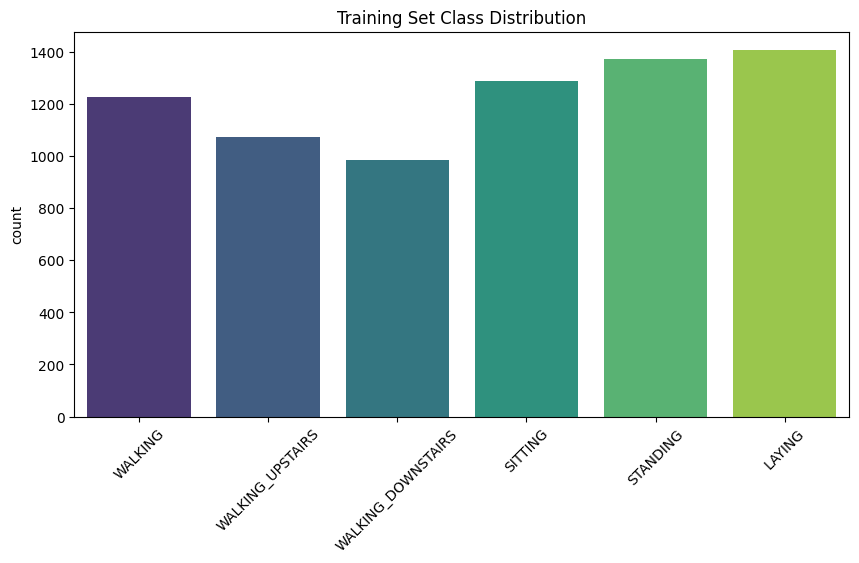

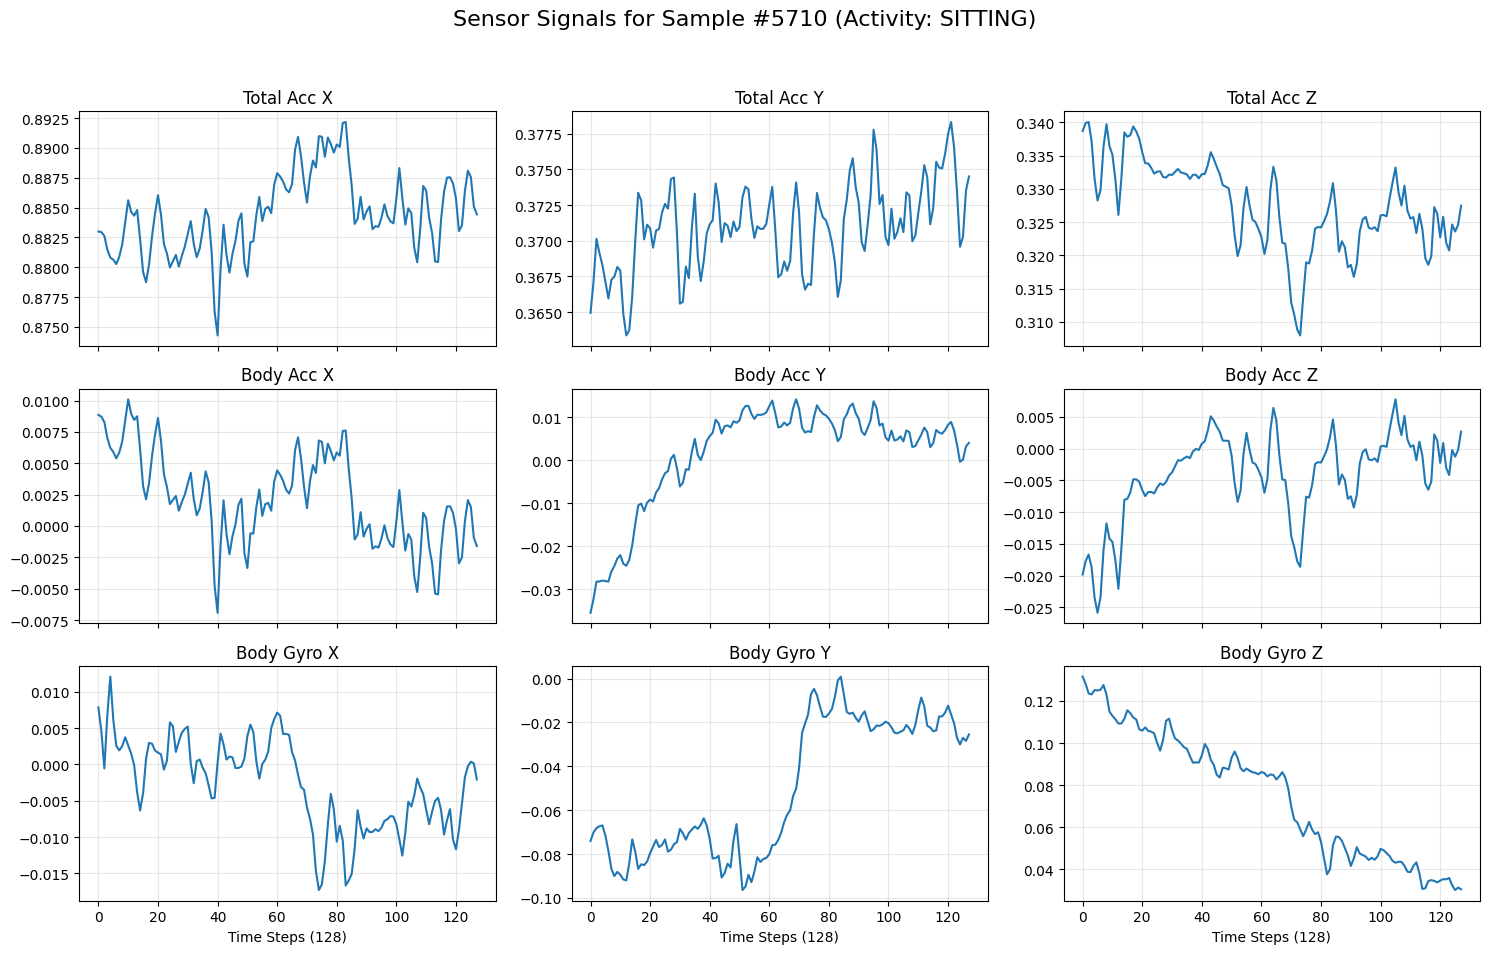

In [13]:
# --- 실행 코드 ---
# load_dataset() 호출 이후에 아래 코드를 실행하세요.
# trainX, trainy는 load_dataset()의 반환값입니다.
inspect_and_visualize_data(trainX, trainy, title_prefix="Training")

# 2. 모델 정의

## 2.1 모델 파라미터 설정

In [14]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [15]:
# 공통 학습 파라미터
EPOCHS = 150
BATCH_SIZE = 64

# 입력 형태 정의
input_shape = (n_timesteps, n_features)

## 2.2 모델 정의

In [16]:
# --- SE Block ---
def squeeze_excite_block(inputs, ratio=16):
    filters = inputs.shape[-1]

    # Squeeze: (Batch, Time, Filters) -> (Batch, Filters)
    se = GlobalAveragePooling1D()(inputs)

    # Excitation: 채널 간 중요도 학습
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # (Batch, 1, Filters)로 변환하여 방송(Broadcast) 연산 준비
    se = Reshape((1, filters))(se)

    # Scale: 입력 특징맵에 중요도 곱하기
    x = Multiply()([inputs, se])
    return x

In [17]:
# --- ResNet Block ---
def resnet_block(inputs, filters, kernel_size=3, stride=1):
    shortcut = inputs
    if stride > 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=l2(5e-5))(inputs) # L2 규제 약화
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Dropout 제거 (Underfitting 해결)

    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=l2(5e-5))(x)
    x = BatchNormalization()(x)

    x = squeeze_excite_block(x) # SE Block

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [18]:
# --- Focal Loss 정의 ---
# gamma: 어려운 샘플에 얼마나 더 집중할지 결정 (일반적으로 2.0 사용)
# alpha: 클래스 불균형 보정 (여기서는 None으로 두어 난이도에만 집중)
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # y_pred가 0이나 1이 되어 log가 무한대로 가는 것을 방지
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Cross Entropy 계산
        cross_entropy = -y_true * K.log(y_pred)

        # Focal Term 계산 (1 - prediction)^gamma
        # 예측 확률이 높으면(잘 맞추면) weight가 0에 가까워짐 -> Loss 감소
        # 예측 확률이 낮으면(틀리면) weight가 커짐 -> Loss 증가
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        return K.sum(weight * cross_entropy, axis=-1)
    return focal_loss_fixed

In [41]:
def build_model(input_shape, n_outputs):
    inputs = Input(shape=input_shape, name='Input')

    x = Conv1D(64, kernel_size=7, strides=2, padding='same', kernel_regularizer=l2(5e-5))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Blocks: 점진적 필터 증가 (64 -> 128 -> 128 -> 256)
    x = resnet_block(x, filters=64, stride=1)
    x = resnet_block(x, filters=128, stride=2)
    x = resnet_block(x, filters=128, stride=1)
    x = resnet_block(x, filters=256, stride=2)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(n_outputs, activation='softmax', kernel_initializer='he_normal')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Light_SE_ResNet")

    # Optimizer & Focal Loss
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.0005, decay_steps=150*50, alpha=0.01
    )
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

    model.compile(
        loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# 3. 모델 빌드

In [42]:
model = build_model(input_shape, n_outputs)

In [43]:
model.summary()

Model: "Light_SE_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 128, 9)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 64, 64)    │      4,096 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 64, 64)    │     12,352 │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 64, 64)    │     12,352 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 4)         │        256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │        256 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1, 64)     │          0 │ dense_28[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 64)    │          0 │ multiply_12[0][0… │
│                     │                   │            │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 64, 64)    │          0 │ add_12[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 32, 128)   │     24,704 │ activation_29[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 32, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 558,854 (2.13 MB)

 Trainable params: 555,654 (2.12 MB)

 Non-trainable params: 3,200 (12.50 KB)

# 4. 모델 학습

In [44]:
# Callbacks 정의
# 15 Epochs 동안 val_loss가 개선되지 않으면 학습 중단 및 최적 가중치 복원
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# 5 Epochs 동안 val_loss가 개선되지 않으면 학습률을 0.5배로 감소
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks = [early_stopping]

In [45]:
history = model.fit(
    X_train_scaled, # 스케일링된 데이터 사용
    y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val_one_hot), # 스케일링된 데이터 사용
    verbose=2,
    callbacks=callbacks, # 콜백 적용
)

Epoch 1/150
92/92 - 24s - 266ms/step - accuracy: 0.8822 - loss: 0.0865 - val_accuracy: 0.8620 - val_loss: 0.1232
Epoch 2/150
92/92 - 6s - 64ms/step - accuracy: 0.9342 - loss: 0.0619 - val_accuracy: 0.9184 - val_loss: 0.0772
Epoch 3/150
92/92 - 1s - 10ms/step - accuracy: 0.9420 - loss: 0.0584 - val_accuracy: 0.9504 - val_loss: 0.0558
Epoch 4/150
92/92 - 1s - 10ms/step - accuracy: 0.9430 - loss: 0.0548 - val_accuracy: 0.9538 - val_loss: 0.0520
Epoch 5/150
92/92 - 1s - 8ms/step - accuracy: 0.9486 - loss: 0.0519 - val_accuracy: 0.9490 - val_loss: 0.0504
Epoch 6/150
92/92 - 1s - 7ms/step - accuracy: 0.9503 - loss: 0.0496 - val_accuracy: 0.9511 - val_loss: 0.0488
Epoch 7/150
92/92 - 1s - 7ms/step - accuracy: 0.9520 - loss: 0.0463 - val_accuracy: 0.9572 - val_loss: 0.0445
Epoch 8/150
92/92 - 1s - 8ms/step - accuracy: 0.9495 - loss: 0.0456 - val_accuracy: 0.9565 - val_loss: 0.0437
Epoch 9/150
92/92 - 1s - 7ms/step - accuracy: 0.9522 - loss: 0.0422 - val_accuracy: 0.9585 - val_loss: 0.0401
Epoc

# 4. 결과 분석 및 평가

## 4.1 학습 과정 시각화 (Loss & Accuracy)

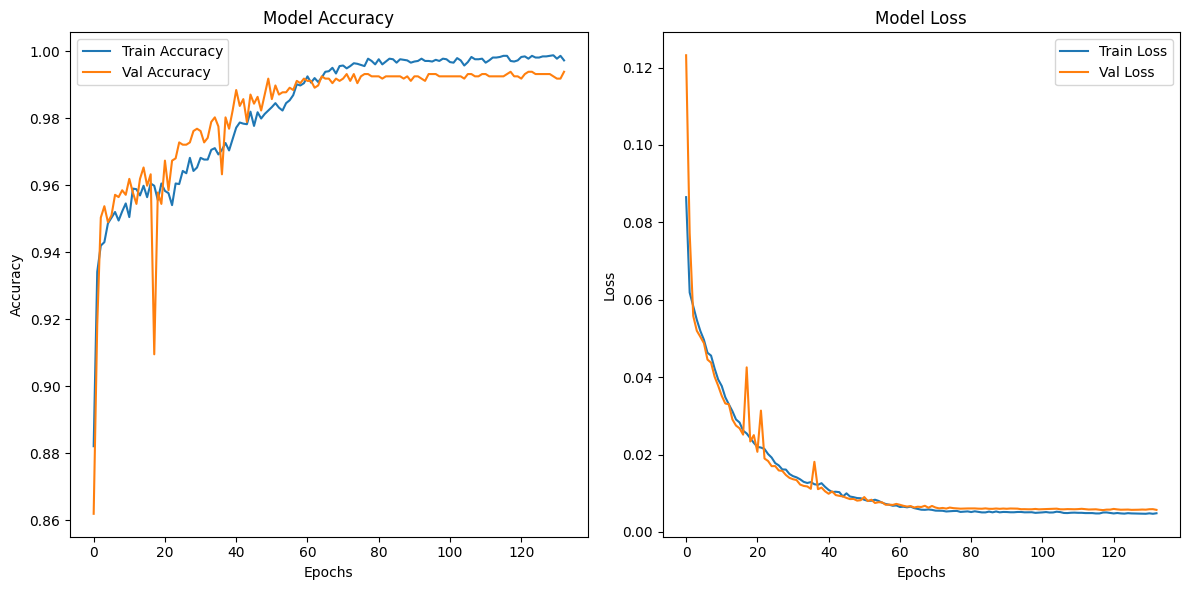

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 4.2 테스트 세트 평가 (Confusion Matrix)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy: 0.9661

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       0.98      0.97      0.97       471
           2       0.96      1.00      0.98       420
           3       0.97      0.86      0.91       491
           4       0.90      0.98      0.94       532
           5       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



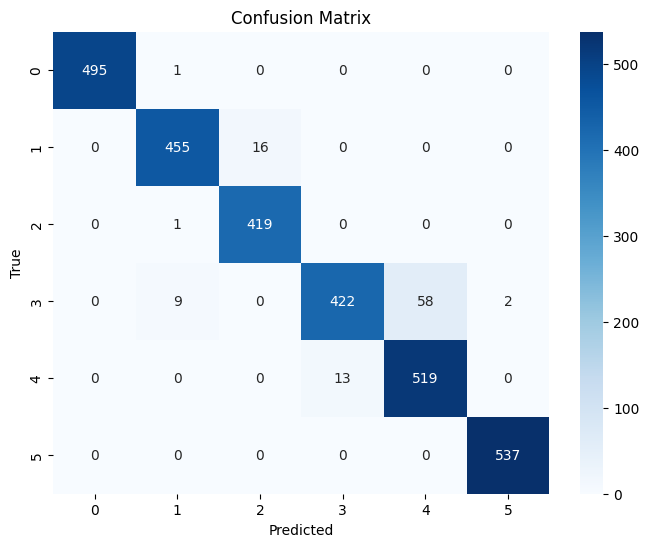

In [47]:
pred_probs = model.predict(testX_scaled)
pred_classes = np.argmax(pred_probs, axis=-1)

print(f"Accuracy: {accuracy_score(testy, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(testy, pred_classes))

cm = confusion_matrix(testy, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()